# Project 4: WeRateDogs data wrangling

## Table of contents

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
    <ul>
        <li><a href="#gathering">Data gathering</a></li>
        <li><a href="#assessment">Data assessment</a></li>
        <li><a href="#cleaning">Data cleaning</a></li>
        <li><a href="#storing">Data storing</a></li>
    </ul>
<li><a href="#av">Analysis and Visualization</a></li>
</ul>

<a id='intro'></a>
## Introduction 

In this project, we will be wrangling, analysing and visualizing  the tweet archive of Twitter user [@dog_rates](https://twitter.com/dog_rates), also known as [WeRateDogs](https://en.wikipedia.org/wiki/WeRateDogs). After gathering this data from Twitter's api (with [Tweepy](https://www.tweepy.org/)), we will be assessing and cleaning it. Finally, we will be finding useful insights from our cleaned data and producing some visualizations.

<a id='wrangling'></a>
## Data wrangling 

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import tweepy 
import os
import time
import json
import requests
from PIL import Image
from io import BytesIO
import sqlite3

<a id='gathering'></a>
### Data gathering

#### `1.` WeRateDogs archive

In [2]:
# load WeRateDogs archive into dataframe
archive = pd.read_csv('../data/twitter-archive-enhanced.csv')
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### `2.` Tweets' image predictions.

In [3]:
# download 'image_predictions.tsv' into data folder
folder_path = '../data'
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
with open(os.path.join(folder_path, url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)        

In [4]:
# check if file in data folder
os.listdir(folder_path)

['twitter_archive_master.csv',
 'image-predictions.tsv',
 'we-rate-dogs.db',
 'twitter-archive-enhanced.csv',
 'image_predictions_master.csv',
 'tweet_json.txt']

In [5]:
# load 'image_predictions.tsv' into dataframe
image_predictions = pd.read_csv('../data/image-predictions.tsv', sep='\t')
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### `3.` Retweet count and favorite count.

In [6]:
# WeRateDogs tweet ids
tweet_id_list = list(archive.tweet_id)
tweet_id_list

[892420643555336193,
 892177421306343426,
 891815181378084864,
 891689557279858688,
 891327558926688256,
 891087950875897856,
 890971913173991426,
 890729181411237888,
 890609185150312448,
 890240255349198849,
 890006608113172480,
 889880896479866881,
 889665388333682689,
 889638837579907072,
 889531135344209921,
 889278841981685760,
 888917238123831296,
 888804989199671297,
 888554962724278272,
 888202515573088257,
 888078434458587136,
 887705289381826560,
 887517139158093824,
 887473957103951883,
 887343217045368832,
 887101392804085760,
 886983233522544640,
 886736880519319552,
 886680336477933568,
 886366144734445568,
 886267009285017600,
 886258384151887873,
 886054160059072513,
 885984800019947520,
 885528943205470208,
 885518971528720385,
 885311592912609280,
 885167619883638784,
 884925521741709313,
 884876753390489601,
 884562892145688576,
 884441805382717440,
 884247878851493888,
 884162670584377345,
 883838122936631299,
 883482846933004288,
 883360690899218434,
 883117836046

In [7]:
# retrieve api credential from we-rate-dogs sqlite database located in ../data/we-rate-dogs.db
 
db = sqlite3.connect('../data/we-rate-dogs.db')
cursor = db.execute('SELECT * FROM auth;')
auth_args = []
for consumer_key, consumer_secret, access_token, access_secret in cursor.fetchall():
    auth_args.append((consumer_key, consumer_secret, access_token, access_secret))

In [8]:
# instantiate a tweepy object 

auth = tweepy.OAuthHandler(auth_args[0][0], auth_args[0][1])
auth.set_access_token(auth_args[0][2], auth_args[0][3])

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [ ]:
# File path to save tweets' content
tweet_json_path = '../data/tweet_json.txt'
# Quering twitter ids in 'twitter_ids_list'
for tweet_id in tweet_id_list: 
    try:
        start_time = time.time() # start timing request 
        tweet = api.get_status(tweet_id, tweet_mode="extended")
        end_time = time.time() # end timing request
        print(f" Sucess! Tweet id: {tweet_id}. Request duration: {end_time - start_time}") 
        # Writing Twitter Json file into ../data/tweet_json.txt file.
        tweet_json =[]
        tweet_json.append({tweet.id: f'{tweet.retweet_count} {tweet.favorite_count}'}) 
        with open(tweet_json_path, mode='a', encoding='utf-8') as file:
            json.dump(tweet_json[0], file)
            file.write("\n")
    except:
        print(f"⚠️ Fail ⚠️ Tweet associated with the id {tweet_id} has been deleted")

Tweet id: 892420643555336193. Request duration: 7.184101343154907
Tweet id: 892177421306343426. Request duration: 0.8641998767852783
Tweet id: 891815181378084864. Request duration: 0.875007152557373


In [9]:
# Strip a set of characters from a string, Source: https://www.w3resource.com/python-exercises/string/python-data-type-string-exercise-41.php
def strip_chars(str, chars):
    return "".join(c for c in str if c not in chars)

In [10]:
# Read data from tweet_json.txt and append it to tweet_json_list using this template: f'{tweet_id} {retweet_count} {favorite_count}'
tweet_json_list = []

with open('../data/tweet_json.txt', mode='r+', encoding='utf-8') as file:
    for line in file.readlines():
        line = strip_chars(line, '{}":\n')
        tweet_json_list.append(line)

In [11]:
# create tweet_json  dataframe and populate its column 'tweet' with tweet_json_list content.
tweet_json = pd.DataFrame(tweet_json_list, columns=['tweet'])

In [12]:
# Create tweet_id, retweet_count and favorite_count columns with the right fit data
tweet_json['tweet_id'] = tweet_json.tweet.str.extract(r'([0-9]+(?=\s))').astype(int)

tweet_json['retweet_count'] = tweet_json.tweet.str.extract(r'((?<=\s)[0-9]+(?=\s))').astype(int)

tweet_json['favorite_count'] = tweet_json.tweet.str.extract(r'[\s]{1}([0-9]+)$').replace(' ','').astype(int)

In [13]:
# drop column tweet_json
tweet_json.drop('tweet', axis='columns', inplace=True)

In [14]:
tweet_json.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7487,35458
1,892177421306343426,5557,30696
2,891815181378084864,3680,23088
3,891689557279858688,7664,38741
4,891327558926688256,8265,37024


<a id='assessment'></a>
### Data assessment

#### `archive` table

In [15]:
archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [16]:
# df_twitter's columns
list(archive)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

In [17]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [18]:
list(archive.name)

['Phineas',
 'Tilly',
 'Archie',
 'Darla',
 'Franklin',
 'None',
 'Jax',
 'None',
 'Zoey',
 'Cassie',
 'Koda',
 'Bruno',
 'None',
 'Ted',
 'Stuart',
 'Oliver',
 'Jim',
 'Zeke',
 'Ralphus',
 'Canela',
 'Gerald',
 'Jeffrey',
 'such',
 'Canela',
 'None',
 'None',
 'Maya',
 'Mingus',
 'Derek',
 'Roscoe',
 'None',
 'Waffles',
 'None',
 'Jimbo',
 'Maisey',
 'None',
 'Lilly',
 'None',
 'Earl',
 'Lola',
 'Kevin',
 'None',
 'None',
 'Yogi',
 'Noah',
 'Bella',
 'Grizzwald',
 'None',
 'Rusty',
 'Gus',
 'Stanley',
 'Alfy',
 'Koko',
 'Rey',
 'Gary',
 'None',
 'a',
 'Elliot',
 'Louis',
 'None',
 'Bella',
 'Jesse',
 'None',
 'Romeo',
 'None',
 'Bailey',
 'Duddles',
 'Jack',
 'Emmy',
 'Steven',
 'Beau',
 'Snoopy',
 'None',
 'Shadow',
 'Terrance',
 'Shadow',
 'Emmy',
 'Aja',
 'None',
 'Penny',
 'Dante',
 'Nelly',
 'Ginger',
 'None',
 'Benedict',
 'Venti',
 'Goose',
 'Nugget',
 'None',
 'None',
 'Cash',
 'Coco',
 'Jed',
 'None',
 'Sebastian',
 'Walter',
 'None',
 'Sierra',
 'Sierra',
 'None',
 'None',
 

In [19]:
archive.name.value_counts()

None       745
a           55
Charlie     12
Cooper      11
Lucy        11
          ... 
Ember        1
Jimbo        1
Goliath      1
Lenox        1
Crouton      1
Name: name, Length: 957, dtype: int64

In [20]:
list(archive.name.sort_values())

['Abby',
 'Abby',
 'Ace',
 'Acro',
 'Adele',
 'Aiden',
 'Aja',
 'Akumi',
 'Al',
 'Albert',
 'Albert',
 'Albus',
 'Albus',
 'Aldrick',
 'Alejandro',
 'Alexander',
 'Alexanderson',
 'Alf',
 'Alfie',
 'Alfie',
 'Alfie',
 'Alfie',
 'Alfie',
 'Alfy',
 'Alice',
 'Alice',
 'Amber',
 'Ambrose',
 'Amy',
 'Amélie',
 'Anakin',
 'Anakin',
 'Andru',
 'Andy',
 'Angel',
 'Anna',
 'Anthony',
 'Antony',
 'Apollo',
 'Aqua',
 'Archie',
 'Archie',
 'Archie',
 'Archie',
 'Arlen',
 'Arlo',
 'Arnie',
 'Arnie',
 'Arnie',
 'Arnold',
 'Arya',
 'Ash',
 'Ash',
 'Asher',
 'Ashleigh',
 'Aspen',
 'Aspen',
 'Astrid',
 'Astrid',
 'Atlas',
 'Atlas',
 'Atticus',
 'Atticus',
 'Aubie',
 'Augie',
 'Autumn',
 'Ava',
 'Ava',
 'Axel',
 'Axel',
 'Bailey',
 'Bailey',
 'Bailey',
 'Bailey',
 'Bailey',
 'Bailey',
 'Bailey',
 'Baloo',
 'Baloo',
 'Balto',
 'Balto',
 'Banditt',
 'Banjo',
 'Barclay',
 'Barney',
 'Baron',
 'Barry',
 'Batdog',
 'Bauer',
 'Baxter',
 'Baxter',
 'Bayley',
 'BeBe',
 'Bear',
 'Bear',
 'Bear',
 'Bear',
 'Beau

In [21]:
archive[['name', 'text']]

,name,text
0,Phineas,This is Phineas. He's a mystical boy. Only eve...
1,Tilly,This is Tilly. She's just checking pup on you....
2,Archie,This is Archie. He is a rare Norwegian Pouncin...
3,Darla,This is Darla. She commenced a snooze mid meal...
4,Franklin,This is Franklin. He would like you to stop ca...
...,...,...
2351,None,Here we have a 1949 1st generation vulpix. Enj...
2352,a,This is a purebred Piers Morgan. Loves to Netf...
2353,a,Here is a very happy pup. Big fan of well-main...
2354,a,This is a western brown Mitsubishi terrier. Up...


In [22]:
archive[['name', 'text']].sort_values('name')

,name,text
1035,Abby,This is Abby. She got her face stuck in a glas...
1021,Abby,Meet Abby. She's incredibly distracting. Just ...
938,Ace,This is Ace. He's a window washer. One of the ...
1933,Acro,This is Acro. You briefly see her out of the c...
1327,Adele,This is Adele. Her tongue flies out of her mou...
...,...,...
1031,very,We only rate dogs. Pls stop sending in non-can...
773,very,RT @dog_rates: We only rate dogs. Pls stop sen...
1097,very,We only rate dogs. Please stop sending in non-...
819,very,We only rate dogs. Pls stop sending in non-can...


In [23]:
# Match names that start with a lower case letter
archive[archive.name.str.match('[^A-Z]')].name.unique()

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
       'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

In [24]:
# wrong name 'my' 
archive.query('name == "my"')['text']

852    This is my dog. Her name is Zoey. She knows I'...
Name: text, dtype: object

In [25]:
# wrong name Al
archive.query('name == "Al"')['text']

820    Meet Al Cabone. He's a gangsta puppa. Rather h...
Name: text, dtype: object

In [26]:
# wrong name O
archive.query('name == "O"')['text']

775    This is O'Malley. That is how he sleeps. Doesn...
Name: text, dtype: object

In [27]:
# Match single letter names
archive[archive.name.str.contains(r'^[A-Z]{1}$')].name.unique()

array(['O'], dtype=object)

In [28]:
list(archive.source)

['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com/download/ipho

In [29]:
archive[['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
0,This is Phineas. He's a mystical boy. Only eve...,13,10
1,This is Tilly. She's just checking pup on you....,13,10
2,This is Archie. He is a rare Norwegian Pouncin...,12,10
3,This is Darla. She commenced a snooze mid meal...,13,10
4,This is Franklin. He would like you to stop ca...,12,10
...,...,...,...
2351,Here we have a 1949 1st generation vulpix. Enj...,5,10
2352,This is a purebred Piers Morgan. Loves to Netf...,6,10
2353,Here is a very happy pup. Big fan of well-main...,9,10
2354,This is a western brown Mitsubishi terrier. Up...,7,10


#### `image_predictions` table

In [30]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [31]:
# df_image_predictions' columns
list(image_predictions)

['tweet_id',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

In [32]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### `tweet_json` table

In [33]:
tweet_json

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7487,35458
1,892177421306343426,5557,30696
2,891815181378084864,3680,23088
3,891689557279858688,7664,38741
4,891327558926688256,8265,37024
...,...,...,...
2326,666049248165822465,40,96
2327,666044226329800704,125,264
2328,666033412701032449,39,109
2329,666029285002620928,41,119


In [34]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
tweet_id          2331 non-null int64
retweet_count     2331 non-null int64
favorite_count    2331 non-null int64
dtypes: int64(3)
memory usage: 54.8 KB


### Tidiness

1. Tweets to keep in the **`archive`** table are those in **`image_predictions`** table.


2. Retweet count and favorite count in **`tweet_json`** table should in **`archive`** table.


3. Column `text` in **`archive`** table contains URLs that should be removed since there is a column **expanded_urls** that can direct to the tweet. 


4. Dog Stages `doggo, floofer, pupper, puppo`  should be stored in `stage` column in **`archive`** table.


5. `img_num` is not an appealing variable name since it corresponds to the best predictions.

### Quality

##### `archive` table 

1. `timestamp` data type should be datatime.


2. `expanded_urls`, missing values


3. `name` **Zoey** instead of **my** 


4. `name` **Al Cabone** instead of **Al**


5. `name` **O'Malley** instead of **O**. Check single letter names.

 
6. `name` **Quizno** instead of **his**. Seems not to be a dog.


7. **a, not, one, an, just, very, actually, such, the, this, unacceptable,....** instead of **None** or names. These names seems to be lower case. 


8. `source` column as Text-formatted string instead HTML-formatted string for clarity.


9. Some `rating numerators` and `denominators` don't match with rating in text column.


10. `in_reply_to_user_id`, `in_reply_to_status_id`, `retweeted_status_id`, `retweeted_status_user_id` in **string** instead **float**. Missing values.


11. `retweeted_status_timestamp` data type should be a datatime.

##### `image_predictions` table 

12. `img_num` data type should be categorical and it values more appealing

<a id='cleaning'></a>
### Data cleaning

In [35]:
# make a copy of original data
archive_clean = archive.copy()
image_predictions_clean = image_predictions.copy()
tweet_json_clean = tweet_json.copy()

### Tidiness

#### `1.` 

Tweets to keep in the `archive` table are those in `image_predictions` table.

###### Define

Select rows in `archive` table based on `image_predictions` tweet_id column. 

###### Code

In [36]:
archive_clean = archive_clean[archive_clean.tweet_id.isin(image_predictions_clean.tweet_id)]

###### Test

In [37]:
archive_clean.shape[0] == image_predictions_clean.shape[0]

True

#### `2.` 

Retweet count and favorite count in `tweet_json` table should in `archive` table.

###### Define

Merge retweet_count and favorite_count columns to `archive` table joining on tweet_id

###### Code

In [38]:
archive_clean = pd.merge(archive_clean, tweet_json_clean, on='tweet_id', how='inner')

###### Test

In [39]:
all_columns = pd.Series(list(archive_clean) + list(tweet_json))
all_columns[all_columns.duplicated()]

19          tweet_id
20     retweet_count
21    favorite_count
dtype: object

#### `3.` 

Column text in `archive` table contains URLs that should be removed since there is a column expanded_urls that can direct to the tweet. 

###### Define

Match url pattern in the text and delete it. 

###### Code

In [40]:
archive_clean.text = archive_clean.text.str.extract(r'([\w\s\W]+(?=\shttp[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+))')

###### Test

In [41]:
archive_clean.text

0       This is Phineas. He's a mystical boy. Only eve...
1       This is Tilly. She's just checking pup on you....
2       This is Archie. He is a rare Norwegian Pouncin...
3       This is Darla. She commenced a snooze mid meal...
4       This is Franklin. He would like you to stop ca...
                              ...                        
2054    Here we have a 1949 1st generation vulpix. Enj...
2055    This is a purebred Piers Morgan. Loves to Netf...
2056    Here is a very happy pup. Big fan of well-main...
2057    This is a western brown Mitsubishi terrier. Up...
2058    Here we have a Japanese Irish Setter. Lost eye...
Name: text, Length: 2059, dtype: object

In [42]:
archive_clean.text[0]

"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10"

#### `4.` 

Dog Stages (doggo, floofer, pupper, puppo)  should be stored in **stage** column in `archive` table.

#### Define

Melt doggo, floofer, pupper, puppo to a column **stage**

#### Code

In [43]:
archive_clean['stage'] = (archive_clean['doggo'] + archive_clean['floofer'] + archive_clean['pupper'] + archive_clean['puppo']).str.strip()

In [44]:
archive_clean.stage = archive_clean.stage.apply(lambda x: x.replace('None','').strip())

In [45]:
archive_clean.stage.value_counts()

                1741
pupper           210
doggo             65
puppo             23
doggopupper       11
floofer            7
doggofloofer       1
doggopuppo         1
Name: stage, dtype: int64

In [46]:
archive_clean.stage = archive_clean.stage.replace({'':'None', 'doggopupper': 'puppo', 'doggofloofer': 'floofer', 'doggopuppo': 'doggo'})

In [47]:
archive_clean.drop(columns=['doggo', 'floofer', 'pupper','puppo'], axis=1, inplace=True)

#### Test

In [48]:
archive_clean.shape

(2059, 16)

In [49]:
archive_clean.stage.value_counts()

None       1741
pupper      210
doggo        66
puppo        34
floofer       8
Name: stage, dtype: int64

#### `5.` 

`img_num` is not an appealing variable name since it corresponds to the best predictions.

#### Define 

Change `img_num` to `best_prediction`

#### Code

In [50]:
image_predictions_clean.rename(columns={'img_num':'best_prediction'}, inplace=True)

#### Test

In [51]:
list(image_predictions_clean)

['tweet_id',
 'jpg_url',
 'best_prediction',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

### Quality

##### `archive` table 

#### `1.` 

`timestamp` data type should be datatime.

####  Define

Convert timestamp to datetime

#### Code

In [52]:
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)

#### Test

In [53]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 16 columns):
tweet_id                      2059 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2059 non-null datetime64[ns, UTC]
source                        2059 non-null object
text                          2059 non-null object
retweeted_status_id           72 non-null float64
retweeted_status_user_id      72 non-null float64
retweeted_status_timestamp    72 non-null object
expanded_urls                 2059 non-null object
rating_numerator              2059 non-null int64
rating_denominator            2059 non-null int64
name                          2059 non-null object
retweet_count                 2059 non-null int64
favorite_count                2059 non-null int64
stage                         2059 non-null object
dtypes: datetime64[ns, UTC](1), float64(4), int64(5), object(6)
memory usag

`2.`

`expanded_urls`, missing 59 values

#### Define

Select rows with missing values and fill them with **None**.

#### Code

In [54]:
archive_clean[archive_clean.expanded_urls.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,stage


### [Resolved] 

There is any missing value in `expanded_urls` column anymore. Done thanks to the **selection of rows in `archive` table based on** `image_predictions` **tweet_id column.**

#### Test

In [55]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 16 columns):
tweet_id                      2059 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2059 non-null datetime64[ns, UTC]
source                        2059 non-null object
text                          2059 non-null object
retweeted_status_id           72 non-null float64
retweeted_status_user_id      72 non-null float64
retweeted_status_timestamp    72 non-null object
expanded_urls                 2059 non-null object
rating_numerator              2059 non-null int64
rating_denominator            2059 non-null int64
name                          2059 non-null object
retweet_count                 2059 non-null int64
favorite_count                2059 non-null int64
stage                         2059 non-null object
dtypes: datetime64[ns, UTC](1), float64(4), int64(5), object(6)
memory usag

#### `3.`

`name` **Zoey** instead of **my**

#### Define

Replace **my** by **Zoey**

#### Code

In [56]:
archive_clean.name.replace('my', 'Zoey', inplace=True)

#### Test

In [57]:
archive_clean.query('name == "my"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,stage


#### `4.`

`name` **Al Cabone** instead of **Al**

#### Define

Replace **Al Cabone** by **Al**

#### Code

In [58]:
archive_clean.name.replace('Al', 'Al Cabone', inplace=True)

#### Test 

In [59]:
archive_clean.query('name == "Al"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,stage


#### `5.` 

`name` **O'Malley** instead of **O**. Check single letter names.

#### Define 

Find single letter names and replace with replace with right names

#### Code

In [60]:
# Match single letter names
archive[archive.name.str.contains(r'^[A-Z]{1}$')].name.unique()

array(['O'], dtype=object)

In [61]:
archive_clean.name.replace('O', "O'Malley", inplace=True)

#### Test

In [62]:
archive_clean.query('name == "O"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,stage


#### `6.` 

`name` **Quizno** instead of **his**. Seems not to be a dog.

#### Define

Delete row with `name` **his**.

#### Code

In [63]:
# find row's index
archive_clean.query('name == "his"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,stage
801,748692773788876800,NaN,NaN,2016-07-01 01:40:41+00:00,"<a href=""http://twitter.com/download/iphone"" r...",That is Quizno. This is his beach. He does not...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/748692773...,10,10,his,1303,4171,doggo


In [64]:
archive_clean.drop(index=801, axis=0, inplace=True)

#### Test

In [65]:
archive_clean.query('name == "his"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,stage


#### `7.`

**a, not, one, an, just, very, actually, such, the, this, unacceptable,....** instead of **None** or names. These names seems to be lower case. 

#### Define

Find list of wrong names. Replace `name` by **None**

#### Code

In [66]:
# Match names that start with a lower case letter
wrong_names = archive_clean[archive_clean.name.str.match('[^A-Z]')].name.unique()
wrong_names

array(['such', 'a', 'quite', 'one', 'incredibly', 'an', 'very', 'just',
       'not', 'getting', 'this', 'unacceptable', 'all', 'infuriating',
       'the', 'actually', 'by', 'officially', 'light', 'space'],
      dtype=object)

In [67]:
archive_clean.replace(wrong_names, 'None', inplace=True)

#### Test

In [68]:
archive_clean[archive_clean.name.isin(wrong_names)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,stage


#### `8.`

`source` column as Text-formatted string instead HTML-formatted string for clarity.

#### Define

Extract text from **a** tag

#### Code

In [69]:
archive_clean.source = archive_clean.source.str.extract(r'((?<=[>])[\w\s]+(?=</a>))')

#### Test

In [70]:
archive_clean.source.head()

0    Twitter for iPhone
1    Twitter for iPhone
2    Twitter for iPhone
3    Twitter for iPhone
4    Twitter for iPhone
Name: source, dtype: object

#### `9.`

Some `rating numerators` and `denominators` don't match with rating in text column.

#### Define

Extract rating from `text` column and fill `rating_numerator` and `rating_denominator` with their right values.

#### Code 

In [71]:
archive_clean['rating'] = archive_clean.text.str.extract(r'(\d+/\d+)')
archive_clean.rating_numerator, archive_clean.rating_denominator = archive_clean.rating.str.split('/', 1).str
archive_clean.rating_numerator = archive_clean.rating_numerator.astype(int)
archive_clean.rating_denominator = archive_clean.rating_denominator.astype(int)
archive_clean.drop(columns='rating', inplace=True)

#### Test

In [72]:
list(archive_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'retweet_count',
 'favorite_count',
 'stage']

In [73]:
archive_clean.rating_numerator.head()

0    13
1    13
2    12
3    13
4    12
Name: rating_numerator, dtype: int64

In [74]:
archive_clean.rating_denominator.head()

0    10
1    10
2    10
3    10
4    10
Name: rating_denominator, dtype: int64

In [75]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2058 entries, 0 to 2058
Data columns (total 16 columns):
tweet_id                      2058 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2058 non-null datetime64[ns, UTC]
source                        2058 non-null object
text                          2058 non-null object
retweeted_status_id           72 non-null float64
retweeted_status_user_id      72 non-null float64
retweeted_status_timestamp    72 non-null object
expanded_urls                 2058 non-null object
rating_numerator              2058 non-null int64
rating_denominator            2058 non-null int64
name                          2058 non-null object
retweet_count                 2058 non-null int64
favorite_count                2058 non-null int64
stage                         2058 non-null object
dtypes: datetime64[ns, UTC](1), float64(4), int64(5), object(6)
memory usag

#### `10.`

`in_reply_to_user_id`, `in_reply_to_status_id`, `retweeted_status_id`, `retweeted_status_user_id` in **string** instead **float**. Missing values.

#### Define

Convert variables into string and replace null values by **None**

#### Code

In [76]:
archive_clean.in_reply_to_status_id = archive_clean.in_reply_to_status_id.astype(str)
archive_clean.in_reply_to_status_id.replace('', 'None', inplace=True)

In [77]:
archive_clean.in_reply_to_user_id = archive_clean.in_reply_to_user_id.astype(str)
archive_clean.in_reply_to_user_id.replace('', 'None', inplace=True)

In [78]:
archive_clean.retweeted_status_id = archive_clean.retweeted_status_id.astype(str)
archive_clean.retweeted_status_id.replace('', 'None', inplace=True)

In [79]:
archive_clean.retweeted_status_user_id = archive_clean.retweeted_status_user_id.astype(str)
archive_clean.retweeted_status_user_id.replace('', 'None', inplace=True)

In [80]:
archive_clean.retweeted_status_id = archive_clean.retweeted_status_id.astype(str)
archive_clean.retweeted_status_id.replace('', 'None', inplace=True)

In [81]:
archive_clean.retweeted_status_user_id = archive_clean.retweeted_status_user_id.astype(str)
archive_clean.retweeted_status_user_id.replace('', 'None', inplace=True)

#### Test

In [82]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2058 entries, 0 to 2058
Data columns (total 16 columns):
tweet_id                      2058 non-null int64
in_reply_to_status_id         2058 non-null object
in_reply_to_user_id           2058 non-null object
timestamp                     2058 non-null datetime64[ns, UTC]
source                        2058 non-null object
text                          2058 non-null object
retweeted_status_id           2058 non-null object
retweeted_status_user_id      2058 non-null object
retweeted_status_timestamp    72 non-null object
expanded_urls                 2058 non-null object
rating_numerator              2058 non-null int64
rating_denominator            2058 non-null int64
name                          2058 non-null object
retweet_count                 2058 non-null int64
favorite_count                2058 non-null int64
stage                         2058 non-null object
dtypes: datetime64[ns, UTC](1), int64(5), object(10)
memory usage: 273.

#### `11.` 

`retweeted_status_timestamp` data type should be a datatime.

#### Define

Convert `retweeted_status_timestamp` to datetime.

#### Code

In [83]:
archive_clean.retweeted_status_timestamp = pd.to_datetime(archive_clean.retweeted_status_timestamp)

#### Test

In [84]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2058 entries, 0 to 2058
Data columns (total 16 columns):
tweet_id                      2058 non-null int64
in_reply_to_status_id         2058 non-null object
in_reply_to_user_id           2058 non-null object
timestamp                     2058 non-null datetime64[ns, UTC]
source                        2058 non-null object
text                          2058 non-null object
retweeted_status_id           2058 non-null object
retweeted_status_user_id      2058 non-null object
retweeted_status_timestamp    72 non-null datetime64[ns, UTC]
expanded_urls                 2058 non-null object
rating_numerator              2058 non-null int64
rating_denominator            2058 non-null int64
name                          2058 non-null object
retweet_count                 2058 non-null int64
favorite_count                2058 non-null int64
stage                         2058 non-null object
dtypes: datetime64[ns, UTC](2), int64(5), object(9)
memory

##### `image_predictions` table 

12. `img_num` data type should be categorical and its value more appealing.

#### Define 

Convert img_num into categorical data type. Replace numbers 1,2,3,4 by categories P1,P2,P3,P4

#### Code

In [85]:
image_predictions_clean.best_prediction.replace({1:'P1', 2:'P2', 3:'P3', 4:'P4'}, inplace=True)

In [86]:
image_predictions_clean.best_prediction = image_predictions_clean.best_prediction.astype('category')

#### Test

In [87]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id           2075 non-null int64
jpg_url            2075 non-null object
best_prediction    2075 non-null category
p1                 2075 non-null object
p1_conf            2075 non-null float64
p1_dog             2075 non-null bool
p2                 2075 non-null object
p2_conf            2075 non-null float64
p2_dog             2075 non-null bool
p3                 2075 non-null object
p3_conf            2075 non-null float64
p3_dog             2075 non-null bool
dtypes: bool(3), category(1), float64(3), int64(1), object(4)
memory usage: 138.1+ KB


In [88]:
image_predictions_clean.best_prediction.value_counts()

P1    1780
P2     198
P3      66
P4      31
Name: best_prediction, dtype: int64

<a id='storing'></a>
### Data storing

In [89]:
# store archive_clean dataframe into twitter_archive_master.csv
archive_clean.to_csv('../data/twitter_archive_master.csv')

In [90]:
# image_predictions_clean dataframe into image_predictions_master.csv
image_predictions_clean.to_csv('../data/image_predictions_master.csv')

<a id='av'></a>
## Analysis and Visualization

In [91]:
# visualization libraries import

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline

The main goal is finding the reason why people retweet or like more some tweets than others. Is it the dog's name, rate, breed or stage that determines whether a tweet is more retweeted or liked?  More specifically, we are looking for the following relationships: 

- **Rate, Retweet count and Favorite count**

- **Stage, Retweet count and Favorite count**

- **Breed, Retweet count and Favorite count.**

But,  before finding how these set of variables relate to each other, we will first find the relationship between Retweet count and Favorite count. 

#### Exploratory data analysis

**`Insight 1:`** Proportion of best breed prediction per algorithm.

In [92]:
best_prediction_count = image_predictions_clean.best_prediction.value_counts()
best_prediction_count

P1    1780
P2     198
P3      66
P4      31
Name: best_prediction, dtype: int64

In [93]:
# Proportion of best breed prediction per algorithm.
image_predictions_clean.best_prediction.value_counts()/image_predictions_clean.shape[0] 

P1    0.857831
P2    0.095422
P3    0.031807
P4    0.014940
Name: best_prediction, dtype: float64

In [94]:
# best algo  count 
best_algo = image_predictions_clean.best_prediction.value_counts()[1]
best_algo

# proportion of best algo
best_prop = best_algo / image_predictions_clean.shape[0]
best_prop

0.09542168674698795

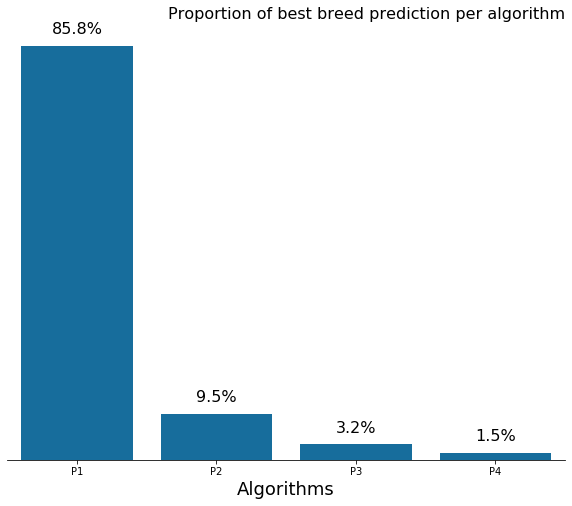

In [95]:
rcParams['figure.figsize'] = 10,8

base_color = sns.color_palette("colorblind")[0]

sns.countplot(data=image_predictions_clean, x='best_prediction', color=base_color);  

for i in range(best_prediction_count.shape[0]):
    count = best_prediction_count[i]
    pct_string = '{:.1f}%'.format(100*count/image_predictions_clean.shape[0])
    plt.text(i, count+50, pct_string, ha='center', size = 16)
plt.xlabel('Algorithms', size=18);

plt.ylabel('')
plt.yticks([],[])

plt.title('Proportion of best breed prediction per algorithm', size=16, loc='right')

sns.despine(left=True)

**`Insight 2:`** How the length of tweets' `text` is distributed 

In [96]:
# compute text length and store it in text_length dataframe

text_length = pd.DataFrame(columns=['length'])
text_length['length']= archive_clean.text.str.len()
text_length.head()

,length
0,85
1,138
2,121
3,79
4,138


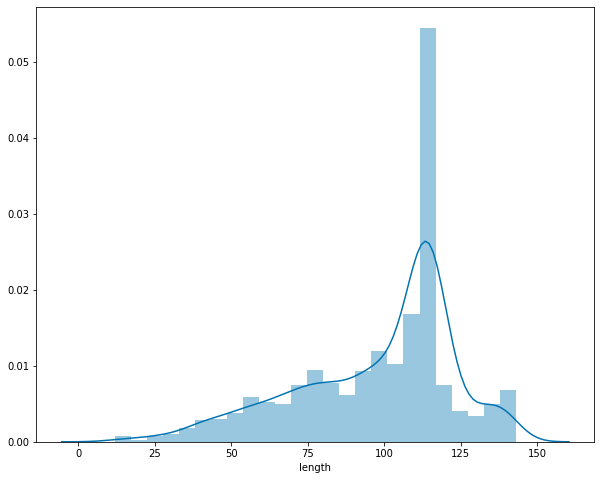

In [97]:
# plot histogram of text_length
base_color = sns.color_palette("colorblind")[0]
sns.distplot(text_length['length'], color=base_color);

**`Insight 3:`** How `retweet_count` relates to `favorite_count`?

In [98]:
archive_clean.retweet_count.describe()

count     2058.000000
mean      2519.487366
std       4400.714783
min         11.000000
25%        540.000000
50%       1190.500000
75%       2897.750000
max      75683.000000
Name: retweet_count, dtype: float64

In [99]:
archive_clean.favorite_count.describe()

count      2058.000000
mean       7826.546161
std       11830.655981
min           0.000000
25%        1486.250000
50%        3435.000000
75%        9750.500000
max      152893.000000
Name: favorite_count, dtype: float64

Text(0.5, 0, "WeRateDogs tweets' like count")

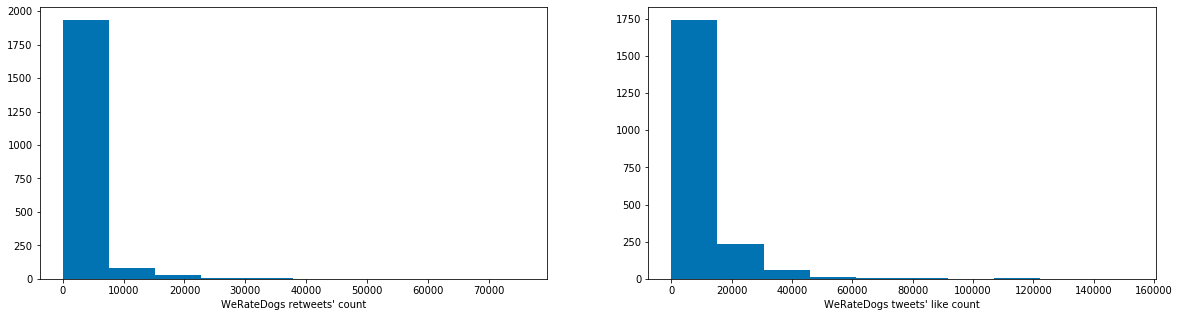

In [100]:
# plot histograms of retweet count and favorite count

# set fig size

plt.figure(figsize = [20, 5])
#color 
base_color = sns.color_palette("colorblind")[0]

# retweet count plot
plt.subplot(1, 2, 1) 
plt.hist(data=archive_clean, x='retweet_count', color=base_color);
plt.xlabel('WeRateDogs retweets\' count')

# favorite count color
plt.subplot(1, 2, 2) 
plt.hist(data=archive_clean, x='favorite_count', color=base_color);
plt.xlabel('WeRateDogs tweets\' like count')

In [101]:
archive_clean[archive_clean['retweet_count'] <= 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,stage


In [102]:
archive_clean[archive_clean['favorite_count'] <= 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,stage
32,885311592912609280,nan,nan,2017-07-13 01:35:06+00:00,Twitter for iPhone,RT @dog_rates: This is Lilly. She just paralle...,8.305833205850685e+17,4196983835.0,2017-02-12 01:04:29+00:00,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,16436,0,None
67,877611172832227328,nan,nan,2017-06-21 19:36:23+00:00,Twitter for iPhone,RT @rachel2195: @dog_rates the boyfriend and h...,8.76850772322988e+17,512804507.0,2017-06-19 17:14:49+00:00,https://twitter.com/rachel2195/status/87685077...,14,10,None,71,0,pupper
107,867072653475098625,nan,nan,2017-05-23 17:40:04+00:00,Twitter for iPhone,RT @rachaeleasler: these @dog_rates hats are 1...,8.650134204453683e+17,7.874617784352891e+17,2017-05-18 01:17:25+00:00,https://twitter.com/rachaeleasler/status/86501...,13,10,None,108,0,None
130,860924035999428608,nan,nan,2017-05-06 18:27:40+00:00,Twitter for iPhone,RT @tallylott: h*ckin adorable promposal. 13/1...,8.609144852504699e+17,363890752.0,2017-05-06 17:49:42+00:00,https://twitter.com/tallylott/status/860914485...,13,10,None,733,0,None
167,851861385021730816,nan,nan,2017-04-11 18:15:55+00:00,Twitter for iPhone,RT @eddie_coe98: Thanks @dog_rates completed m...,8.482893821761004e+17,341021133.0,2017-04-01 21:42:03+00:00,https://twitter.com/eddie_coe98/status/8482893...,10,10,None,19,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,754874841593970688,nan,nan,2016-07-18 03:06:01+00:00,Twitter for iPhone,RT @dog_rates: This is Rubio. He has too much ...,6.791583739888763e+17,4196983835.0,2015-12-22 04:35:49+00:00,https://twitter.com/dog_rates/status/679158373...,11,10,Rubio,7746,0,None
762,752309394570878976,nan,nan,2016-07-11 01:11:51+00:00,Twitter for iPhone,RT @dog_rates: Everyone needs to watch this. 1...,6.75354435921576e+17,4196983835.0,2015-12-11 16:40:19+00:00,https://twitter.com/dog_rates/status/675354435...,13,10,None,15873,0,None
1022,711998809858043904,nan,nan,2016-03-21 19:31:59+00:00,Twitter for iPhone,RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119982797733478e+17,783214.0,2016-03-21 19:29:52+00:00,https://twitter.com/twitter/status/71199827977...,12,10,None,123,0,None
1963,667550904950915073,nan,nan,2015-11-20 03:51:52+00:00,Twitter Web Client,RT @dogratingrating: Exceptional talent. Origi...,6.675486956640707e+17,4296831739.0,2015-11-20 03:43:06+00:00,https://twitter.com/dogratingrating/status/667...,12,10,None,31,0,None


#### Let's try plotting the square-root transformation of retweet_count and favorite_count 

In [103]:
def sqrt_trans(x, inverse = False):
    """ transformation helper function """
    if not inverse:
        return np.sqrt(x)
    else:
        return x ** 2

Text(0.5, 0, "WeRateDogs tweets' like count")

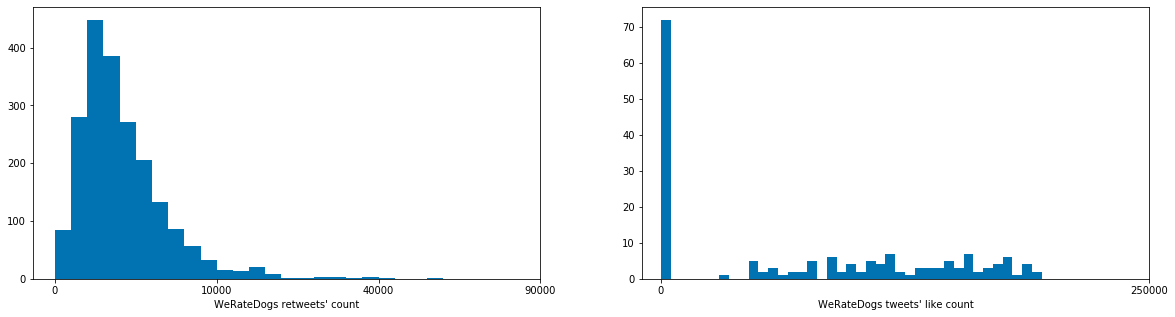

In [104]:
# plot histograms of retweet count and favorite count

# set fig size

plt.figure(figsize = [20, 5])

#color
base_color = sns.color_palette("colorblind")[0]

# retweet count plot
plt.subplot(1, 2, 1) 
bins = np.arange(0, sqrt_trans(archive_clean['retweet_count'].max()+10), 10)
plt.hist(archive_clean['retweet_count'].apply(sqrt_trans), color=base_color, bins=bins);

# Identify the tick-locations
tick_locs = np.arange(0, sqrt_trans(archive_clean['retweet_count'].max())+100, 100)

# Apply x-ticks
plt.xticks(tick_locs, sqrt_trans(tick_locs, inverse = True).astype(int));

plt.xlabel('WeRateDogs retweets\' count')

# favorite count plot
plt.subplot(1, 2, 2) 
bins = np.arange(0, sqrt_trans(archive_clean['favorite_count'].max()+10), 10)
plt.hist(data=archive_clean, x='favorite_count', color=base_color, bins=bins);

# Identify the tick-locations
tick_locs = np.arange(0, sqrt_trans(archive_clean['favorite_count'].max())+500, 500)

# Apply x-ticks
plt.xticks(tick_locs, sqrt_trans(tick_locs, inverse = True).astype(int));

plt.xlabel('WeRateDogs tweets\' like count')

In [141]:
archive_clean[['retweet_count', 'favorite_count']].describe()

,retweet_count,favorite_count
count,2058.000000,2058.000000
mean,2519.487366,7826.546161
std,4400.714783,11830.655981
min,11.000000,0.000000
25%,540.000000,1486.250000
50%,1190.500000,3435.000000
75%,2897.750000,9750.500000
max,75683.000000,152893.000000


#### Let's plot scatterplot and heat map to figure out how retweet_count relates to favorite count

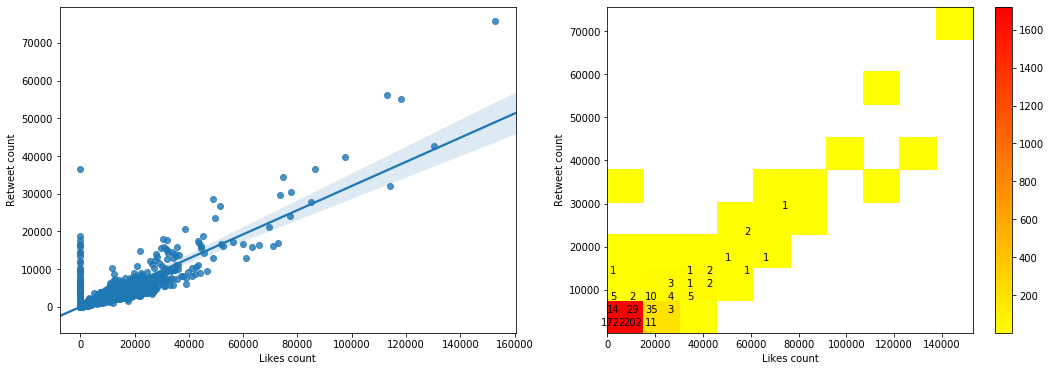

In [161]:
plt.figure(figsize = [18, 6])

#color
base_color = sns.color_palette("colorblind")[0]

# Scatter plot favorite_count on x axis and retweet_count on y axis (on left)
plt.subplot(1, 2, 1)

sns.regplot(data=archive_clean, x='favorite_count', y='retweet_count');
plt.xlabel('Likes count')
plt.ylabel('Retweet count')

# Heat map favorite_count on x axis and retweet_count on y axis
# cmap to reverse the color map.
# cmin specifies the minimum value in a cell before it will be plotted
plt.subplot(1, 2, 2)

# bin edges 
bins_x = np.arange(0, 152893+8000, 8000)
bins_y = np.arange(11, 75683+3000, 3000)

h2d = plt.hist2d(data=archive_clean, x='favorite_count', y='retweet_count', cmap='autumn_r', cmin=1);
plt.colorbar()
plt.xlabel('Likes count')
plt.ylabel('Retweet count')

# Select the bi-dimensional histogram, a 2D array of samples x and y. 
# Values in x are histogrammed along the first dimension and 
# values in y are histogrammed along the second dimension.
counts = h2d[0]

# average of retweet_count's mean and favorite_count's mean
avg_retweet_favorite = (archive_clean.retweet_count.mean() + archive_clean.retweet_count.mean()) / 2

# Add text annotation on each cell
# Loop through the cell counts and add text annotations for each

for i in range(counts.shape[0]):
    
    for j in range(counts.shape[1]):
        
        c = counts[i,j]
        
        if c >= avg_retweet_favorite: # increase visibility on darker cells
            
            plt.text(bins_x[i]+avg_retweet_favorite, bins_y[j]+avg_retweet_favorite, int(c),
                     
                     ha = 'center', va = 'center', color = 'white')
            
        elif c > 0:
            
            plt.text(bins_x[i]+avg_retweet_favorite, bins_y[j]+avg_retweet_favorite, int(c),
                     
                     ha = 'center', va = 'center', color = 'black')

**`Insight 4:`** How dogs' stage relates to favorite count? 

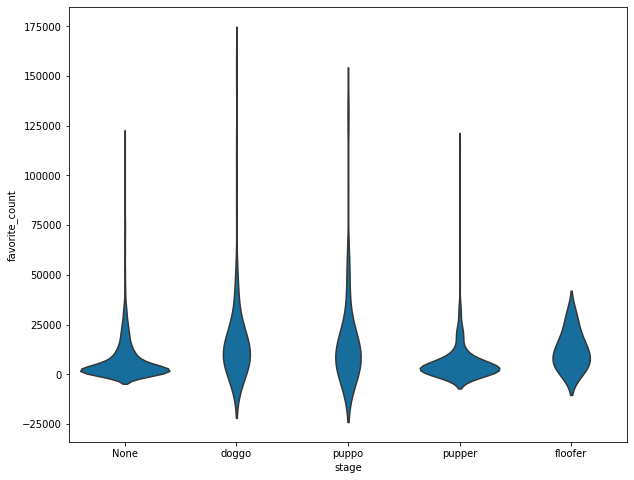

In [185]:
# color
base_color = sns.color_palette("colorblind")[0]

sns.violinplot(data=archive_clean, x='stage', y='favorite_count', color=base_color, inner = None);

**`Insight 5:`** How dogs' stage relates to retweet count? 

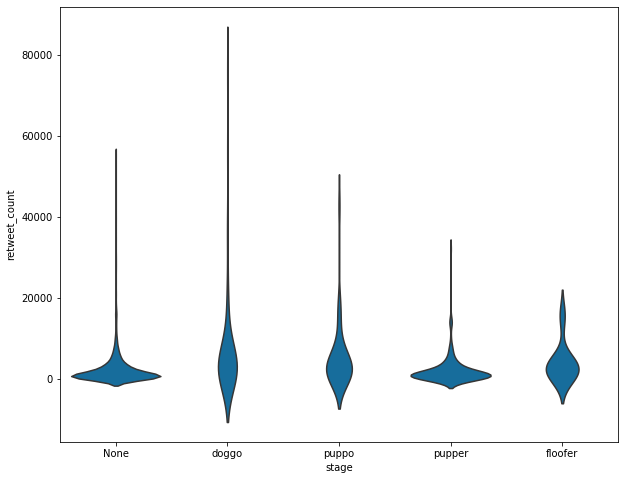

In [188]:
# color
base_color = sns.color_palette("colorblind")[0]

sns.violinplot(data=archive_clean, x='stage', y='retweet_count', color=base_color, inner = None);